In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koodikirjasto as kk
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)

TJTS490 Tietokantajärjestelmät ja data-analytiikka
Harjoitustyö
Susanna Lähde & Aatu Laitinen

Tässä työssä tutkitaan ajoneuvorekisterin dataa. 
Katsotaan millaista tietoa data pitää sisällään:

tähän jotain data explorationia jeejee
esim tutkitaan että millaisia arvoja kolumnit sisältää, onko nulleja (ja mihin ne vaikuttaa) yms yms

Ajatellaan, että olemme autojen jälleenmyyjä ja vaihtoautokauppa. Toimimme Suomen suurimmissa kaupunkikeskuksissa.
Meidän liiketoiminnan jatkuuvuden kannalta tärkeimmät tutkimushypoteesit voisivat olla:
1. Markkinatrendit
2. Alueelliset erot
3. ..?

Tutkitaan ensin markkinatrendejä

In [7]:
df = kk.hybridiautot_luokittain('M1', 2012, 2016)

<connection object at 0x0000026297027450; dsn: 'user=postgres password=xxx dbname=VehicleRegisterDatabase host=192.168.0.15', closed: 0>
Cursor created successfully


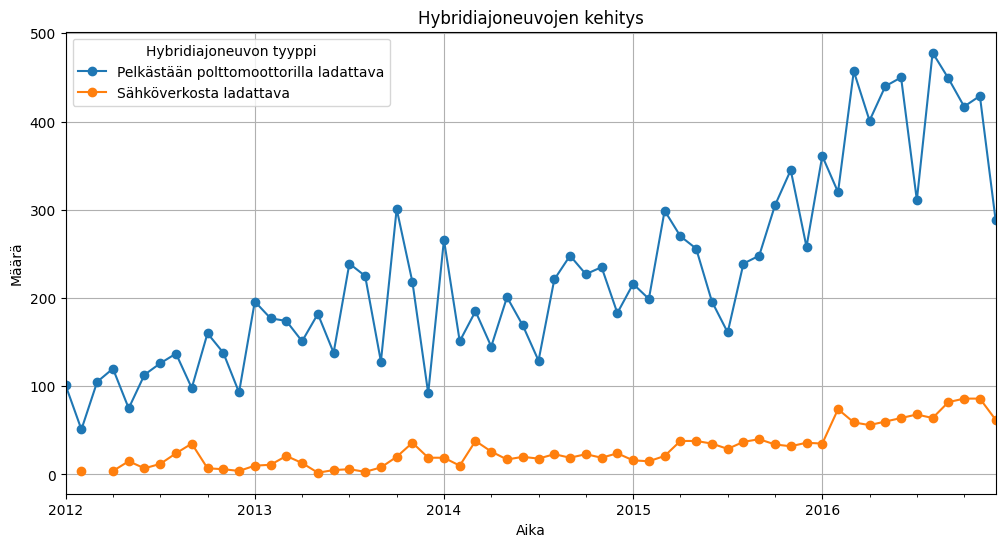

In [8]:
df['date'] = pd.to_datetime(df['vuosi'].astype(str) + '-' + df['kuukausi'].astype(str), format='%Y-%m')
condition = df['hybridityyppi'] == 'Ei määritelty'
df = df[~condition]
df_pivot = df.pivot(index='date', columns='hybridityyppi', values='maara')

fig, ax = plt.subplots(figsize=(12, 6))
df_pivot.plot(ax=ax, marker='o')
plt.title('Hybridiajoneuvojen kehitys')
plt.xlabel('Aika')
plt.ylabel('Määrä')
plt.legend(title='Hybridiajoneuvon tyyppi')
plt.grid(True)
plt.show()


In [ ]:
df = pd.read_csv('Ajoneuvojen_avoin_data_5_21.csv', encoding='ISO-8859-1', on_bad_lines="skip", delimiter=";",low_memory=False)

Otetaan dataa 2010 luvulta eteenpäin

In [ ]:
df['ensirekisterointipvm'] = pd.to_datetime(df['ensirekisterointipvm'])
df = df[df['ensirekisterointipvm'] > '2010-01-01']

Otetaan pelkästään M1 ajoneuvoluokan arvot eli henkilöautot

In [ ]:
df = df[df['ajoneuvoluokka'] == 'M1']

In [ ]:
df

In [ ]:
value_counts_series = df['merkkiSelvakielinen'].dropna().value_counts()
values_to_keep = value_counts_series[value_counts_series > 30000].index
df = df[df['merkkiSelvakielinen'].isin(values_to_keep)]

In [ ]:
df['merkkiSelvakielinen'].dropna().nunique()

In [ ]:
df['merkkiSelvakielinen'].dropna().value_counts()

In [ ]:
plt.figure(figsize=(20, 8))
value_counts = df['merkkiSelvakielinen'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Amount of registered vehicles for every brand with over 30 000 registered vehicles')
plt.show()

In [ ]:

brand_df = df[df['merkkiSelvakielinen'] == 'Volvo']
brand_df['Year'] = (brand_df['ensirekisterointipvm']).dt.year
brand_counts = brand_df.groupby('Year').size()
# Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(brand_counts.index, brand_counts.values, marker='o', linestyle='-')
plt.title('First Registrations for Volvo per year')
plt.xlabel('Year')
plt.ylabel('Number of Registrations')
plt.grid(True)
plt.show()